In [1]:
import pandas
import matplotlib
import collections
import seaborn
import re
import lifelines

%matplotlib inline

seaborn.set_style('whitegrid')
seaborn.set_palette('colorblind')

In [2]:
ecosystems = ['npm', 'cran', 'rubygems']

COLORS = {ecos: seaborn.color_palette()[i] for i, ecos in enumerate(ecosystems)}
FIG_SIZE = (6, 3)
SHOW_TITLE = True

REGEX_FIXED_VERSION = re.compile(r'http|\^|~|>|<|\*|\.x')

In [3]:
def savefig(fig, name):
    # (Un)comment next line to (enable) disable export
    return
    return fig.savefig('../figures/{}.pdf'.format(name), bbox_inches='tight')

In [4]:
def snapshot(date, packages, dependencies):
    """
    Return a 2-uple (packages, dependencies) of dataframes that only contain
    information that were available and valid at given date.
    """
    date = pandas.to_datetime(date)
    pkg = packages[packages['time'] <= date].sort_values('time').groupby(level='package', sort=False).tail(1)
    deps = dependencies.merge(pkg, how='inner', left_on=['package', 'version'], right_index=True)
    deps = deps.drop('time', axis=1)
    return (pkg, deps)

In [5]:
df_pkg = collections.OrderedDict()
df_deps = collections.OrderedDict()

for ecosystem in ecosystems: 
    pkg = pandas.read_csv('../data/{ecosystem}/packages.csv.gz'.format(ecosystem=ecosystem), 
                          usecols=['package', 'version', 'time', 'size'],
                          index_col=['package', 'version'])
    pkg['time'] = pandas.to_datetime(pkg['time'], utc=True, infer_datetime_format=True)
    deps = pandas.read_csv('../data/{ecosystem}/dependencies.csv.gz'.format(ecosystem=ecosystem),
                           usecols=['package', 'version', 'dependency', 'constraint'])

    df_pkg[ecosystem] = pkg
    df_deps[ecosystem] = deps

In [6]:
for ecos, deps in df_deps.items():
    deps['fixed'] = ~ deps['constraint'].str.contains(REGEX_FIXED_VERSION)
    deps['constraint'] = deps['constraint'].where(~deps['fixed'], deps['constraint'].str.replace('=', ''), axis=0)

# Overview

## Number of packages, versions, dependencies (overall/in snapshot)

In [8]:
df = pandas.DataFrame(index=ecosystems)

for ecos in ecosystems:
    latest_date = df_pkg[ecos]['time'].max()
    snapshot_pkg, snapshot_deps = snapshot(latest_date, df_pkg[ecos], df_deps[ecos])
    
    df.loc[ecos, 'packages'] = len(df_pkg[ecos].groupby(level=0))
    df.loc[ecos, 'versions'] = len(df_pkg[ecos])
    df.loc[ecos, 'dependencies'] = len(df_deps[ecos])
    
    df.loc[ecos, 'snapshot'] = latest_date
    df.loc[ecos, 'deps in snapshot'] = len(snapshot_deps)
    
df['versions_mean'] = df['packages'] / df['versions']
df['dependencies_mean'] = df['dependencies'] / df['versions']

df

,packages,versions,dependencies,snapshot,deps in snapshot,versions_mean,dependencies_mean
npm,317159.0,1927750.0,7644295.0,2016-06-28 14:35:28.717,728447.0,0.164523,3.965397
cran,9568.0,57530.0,128113.0,2016-04-26 20:52:26.000,22191.0,0.166313,2.226890
rubygems,122791.0,728173.0,1719656.0,2016-09-07 14:02:43.409,182443.0,0.168629,2.361604


### Evolution of the number of packages/versions

(360, 552)

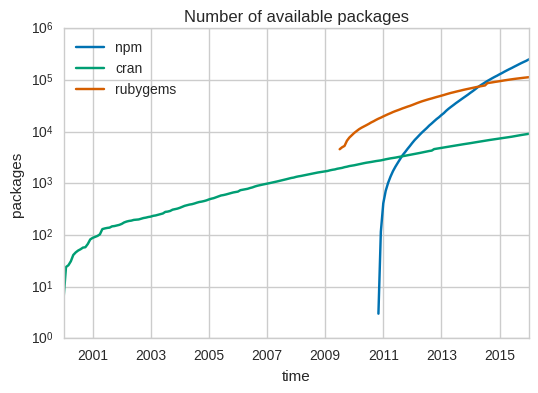

In [24]:
fig, ax = matplotlib.pyplot.subplots()

for ecos, pkg in df_pkg.items():
    df = (pkg
          .query('time >= 2000')
          .groupby(level='package')
          [['time']]
          .min()
          .reset_index()
          .set_index('time')
          .resample('1M')
          .count()
          .rename(columns={'package': ecos})
          [[ecos]]
          .cumsum()
    )
    df.plot(ax=ax, color=COLORS[ecos])

ax.set_title('Number of available packages')
ax.set_yscale('log')
ax.set_ylabel('packages')
ax.set_xlim(left=pandas.to_datetime('2000'), right=pandas.to_datetime('2016'))

(360, 552)

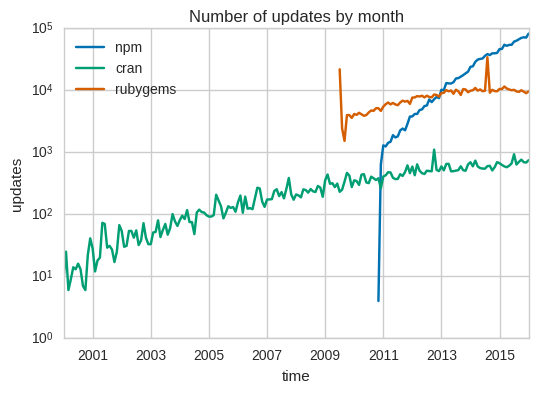

In [25]:
fig, ax = matplotlib.pyplot.subplots()

for ecos, pkg in df_pkg.items():
    df = (pkg
          .query('time >= 2000')
          .groupby(level=['package', 'version'])
          [['time']]
          .min()
          .reset_index()
          .set_index('time')
          .resample('1M')
          .count()
          .rename(columns={'version': ecos})
          [[ecos]]
    )
    df.plot(ax=ax, color=COLORS[ecos])

ax.set_title('Number of updates by month')
ax.set_yscale('log')
ax.set_ylabel('updates')
ax.set_xlim(left=pandas.to_datetime('2000'), right=pandas.to_datetime('2016'))

## Number and proportion of fixed constraints (overall/in snasphot)

In [11]:
df = pandas.DataFrame(index=ecosystems)
df_snapshot = pandas.DataFrame(index=ecosystems)

for ecos in ecosystems:
    latest_date = df_pkg[ecos]['time'].max()
    snapshot_pkg, snapshot_deps = snapshot(latest_date, df_pkg[ecos], df_deps[ecos])
    
    df.loc[ecos, 'versions'] = len(df_pkg[ecos])
    df.loc[ecos, 'versions_with_deps'] = len(df_deps[ecos].groupby(['package', 'version']))
    df.loc[ecos, 'versions_with_fixed'] = len(df_deps[ecos].query('fixed == True').groupby(['package', 'version']))
    df.loc[ecos, 'deps'] = len(df_deps[ecos])
    df.loc[ecos, 'deps_fixed'] = len(df_deps[ecos].query('fixed == True'))
    
    df_snapshot.loc[ecos, 'versions'] = len(snapshot_pkg)
    df_snapshot.loc[ecos, 'versions_with_deps'] = len(snapshot_deps.groupby(['package', 'version']))
    df_snapshot.loc[ecos, 'versions_with_fixed'] = len(snapshot_deps.query('fixed == True').groupby(['package', 'version']))
    df_snapshot.loc[ecos, 'deps'] = len(snapshot_deps)
    df_snapshot.loc[ecos, 'deps_fixed'] = len(snapshot_deps.query('fixed == True'))

df['p_fixed_deps'] = df['deps_fixed'] / df['deps']
df['p_versions_with_fixed'] = df['versions_with_fixed'] / df['versions']
df['p_versions_with_deps_with_fixed'] = df['versions_with_fixed'] / df['versions_with_deps']

df_snapshot['p_fixed_deps'] = df_snapshot['deps_fixed'] / df_snapshot['deps']
df_snapshot['p_versions_with_fixed'] = df_snapshot['versions_with_fixed'] / df_snapshot['versions']
df_snapshot['p_versions_with_deps_with_fixed'] = df_snapshot['versions_with_fixed'] / df_snapshot['versions_with_deps']

df

,versions,versions_with_deps,versions_with_fixed,deps,deps_fixed,p_fixed_deps,p_versions_with_fixed,p_versions_with_deps_with_fixed
npm,1927750.0,1342747.0,404800.0,7644295.0,1395993.0,0.182619,0.209986,0.301472
cran,57530.0,39340.0,14.0,128113.0,19.0,0.000148,0.000243,0.000356
rubygems,728173.0,517887.0,52294.0,1719656.0,121376.0,0.070582,0.071815,0.100976


In [12]:
df_snapshot

,versions,versions_with_deps,versions_with_fixed,deps,deps_fixed,p_fixed_deps,p_versions_with_fixed,p_versions_with_deps_with_fixed
npm,317160.0,186027.0,44370.0,728447.0,113204.0,0.155405,0.139898,0.238514
cran,9568.0,6682.0,5.0,22191.0,6.0,0.000270,0.000523,0.000748
rubygems,122791.0,76029.0,4530.0,182443.0,9000.0,0.049330,0.036892,0.059583


In [13]:
dates = pandas.date_range('2010-01-01', '2016-09-01', freq='12M') - pandas.Timedelta('30D')

df_t_versions = pandas.DataFrame(index=dates, columns=ecosystems)
df_t_deps = pandas.DataFrame(index=dates, columns=ecosystems)
df_t_versions_deps = pandas.DataFrame(index=dates, columns=ecosystems)
df_t_conflict = pandas.DataFrame(index=dates, columns=ecosystems)

divide_by_zero = lambda a, b: a / b if b > 0 else 0

for ecos in ecosystems:
    for date in dates: 
        pkg, deps = snapshot(date, df_pkg[ecos], df_deps[ecos])
        
        packages, dependencies = len(pkg), len(deps)
        packages_with_dependencies = len(deps.groupby('package'))
        fixed_dependencies = len(deps.query('fixed == True'))
        fixed_packages = len(deps.query('fixed == True').groupby('package'))
        
        df_t_versions.loc[date, ecos] = divide_by_zero(fixed_packages, packages)
        df_t_deps.loc[date, ecos] = divide_by_zero(fixed_dependencies, dependencies)
        df_t_versions_deps.loc[date, ecos] = divide_by_zero(fixed_packages, packages_with_dependencies)
        
        # Packages are in conflict if they have the same dependency but with distinct fixed versions
        conflicts = len(deps.query('fixed == True')
                         .merge(deps.query('fixed == True'), how='inner', on=['dependency'], suffixes=['_left', '_right'])
                         .query('constraint_left != constraint_right')
                         .groupby('package_left'))
        df_t_conflict.loc[date, ecos] = divide_by_zero(conflicts / 2, packages)

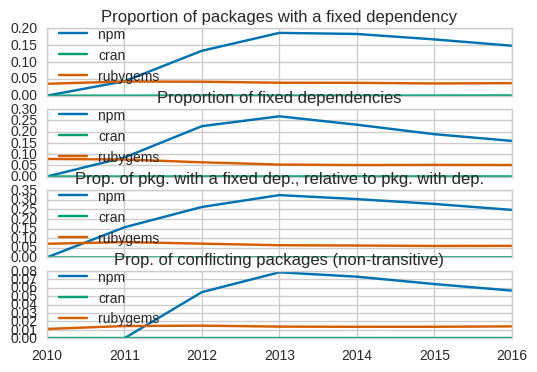

In [14]:
fig, axes = matplotlib.pyplot.subplots(nrows=4, sharex=True)

df_t_versions.plot(ax=axes[0], title='Proportion of packages with a fixed dependency')
df_t_deps.plot(ax=axes[1], title='Proportion of fixed dependencies')
df_t_versions_deps.plot(ax=axes[2], title='Prop. of pkg. with a fixed dep., relative to pkg. with dep.')
df_t_conflict.plot(ax=axes[3], title='Prop. of conflicting packages (non-transitive)')


# Delay

In [7]:
for ecos in ecosystems:
    pkg, deps = df_pkg[ecos], df_deps[ecos]

    # Compute the time for next update
    df = pkg.reset_index().sort_values(['package', 'time']).set_index(['package', 'version'])
    df['next_time'] = df['time'].shift(-1)
    df.loc[df.groupby(level='package', sort=False).tail(1).index, 'next_time'] = pandas.NaT
    
    df_pkg[ecos] = df
    
    # Compute the time for a dependency to be changed
    df = (pkg
          .merge(deps, left_index=True, right_on=['package', 'version'], how='inner')
          .sort_values('time')
          .drop_duplicates(['package', 'dependency', 'constraint'], keep='first')
          .sort_values(['package', 'dependency', 'time'])
          .reset_index(drop=True)
          )

    df['next_time'] = df['time'].shift(-1)
    df.loc[df.groupby(['package', 'dependency'], sort=False).tail(1).index, 'next_time'] = pandas.NaT
    
    df_deps[ecos] = df

## Delay for a package to be updated

(0.0, 18)

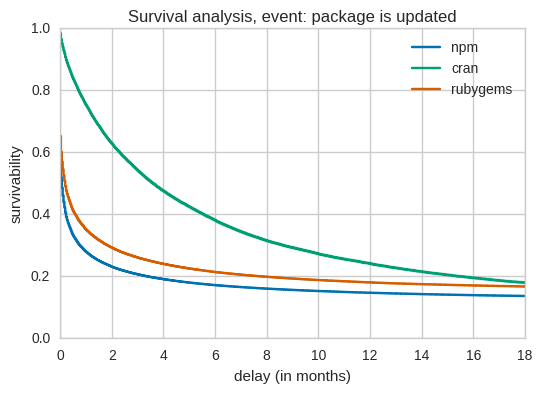

In [18]:
fig, ax = matplotlib.pyplot.subplots(1, 1)

for ecos, df in df_pkg.items(): # [('cran', df_pkg['cran'])]:
    observed = ~df['next_time'].isnull()
    duration = (
        (df['next_time'].fillna(df['time'].max()).astype('datetime64[ns, UTC]')
         - df['time'].astype('datetime64[ns, UTC]')).dt.days / 30
    )
    kmp = lifelines.KaplanMeierFitter()
    kmp.fit(duration, observed, label=ecos)
    kmp.plot(ax=ax, color=COLORS[ecos])
    
ax.set_xlabel('delay (in months)')
ax.set_ylabel('survivability')
ax.set_title('Survival analysis, event: package is updated')
ax.set_xlim(right=18)

## Delay for a dependency to be changed

(0.0, 18)

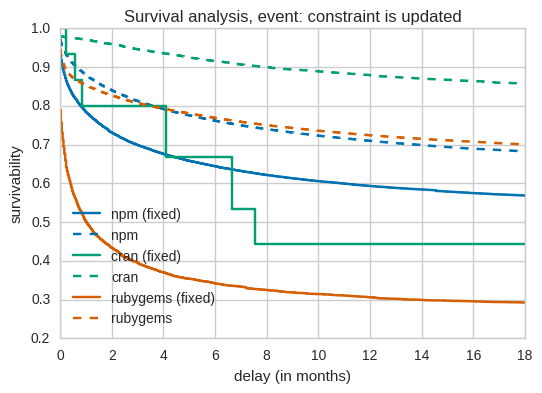

In [28]:
fig, ax = matplotlib.pyplot.subplots(1, 1)

for ecos, df in df_deps.items():
    for is_fixed in [True, False]:
        ndf = df.query('fixed == ' + str(is_fixed))
        observed = ~ndf['next_time'].isnull()
        duration = (
            (ndf['next_time'].fillna(df['time'].max()).astype('datetime64[ns, UTC]')
             - ndf['time'].astype('datetime64[ns, UTC]')).dt.days / 30
        )
        kmp = lifelines.KaplanMeierFitter()
        kmp.fit(duration, observed, label=ecos + ' (fixed)' if is_fixed else ecos)
        kmp.plot(style='-' if is_fixed else '--', 
                 ci_show=False,
                 ax=ax, 
                 color=COLORS[ecos])

ax.set_xlabel('delay (in months)')
ax.set_ylabel('survivability')
ax.set_title('Survival analysis, event: constraint is updated')
ax.set_xlim(right=18)

## From (un)fixed to (un)fixed

 - Delay to switch from a fixed constraint to an unfixed one.
 - Delay to switch from an unfixed constraint to a fixed one.
 - (?) Delay to add a (un)fixed constraint to a package
 - Which are the packages that are more commonly required using an unfixed constraint? Do them update more frequently?